In [1]:
import gym
import numpy as np

from tqdm import trange

env = gym.make('Pendulum-v0')

The pendulum challenge is to keep a 
frictionless pendulum standing up

# The Pendulum

## States

| Num | Observation |
|:-:|:-:|
| 0 | cos(theta) |
| 1 | sin(theta) |
| 2 | theta dot |


<style>
td {
  font-size: 100px
}
    
    
</style>


In [2]:
print(f"The shape of the state space: {env.observation_space.shape}")
print(f"Highest value: {env.observation_space.high}")
print(f"Lowest value: {env.observation_space.low}")

env.observation_space

print(f"A sample state: {env.observation_space.sample()}")

The shape of the state space: (3,)
Highest value: [1. 1. 8.]
Lowest value: [-1. -1. -8.]
A sample state: [-0.49051192 -0.65636176  5.2461014 ]


## Actions

| Num | Action |
|:-:|:-:|
| 0 | Joint effort |

In [3]:
print(f"The shape of the action space: {env.action_space.shape}")
print(f"Highest value: {env.action_space.high}")
print(f"Lowest value: {env.action_space.low}")

env.action_space.seed(473)

print(f"A sample action: {env.action_space.sample()}")

The shape of the action space: (1,)
Highest value: [2.]
Lowest value: [-2.]
A sample action: [-0.8608973]


In [4]:
env.action_space.sample()

array([1.8785995], dtype=float32)

## Reward

Function: $-(theta^2 + 0.1*thetaDot^2 + 0.001*action^2)$

# The Agent

In [5]:
import sys
import numpy as np
import pandas as pd
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

### Utils

In [6]:
# Utils
class ScoreEvaluator:
    def __init__(self, window: int):
        self.window = window
        self.best_score = -np.inf
        self.avg_scores = []
        self.tmp_scores = deque(maxlen=window)
        self.last_score = None
        
    def add(self, score: float):
        if not score:
            raise ValueError(f'Score could not be {score}')
         
        self.tmp_scores.append(score)
        
        if score > self.best_score:
            self.best_score = score
        
        self._update_avg()
        self.last_score = score
        
    def plot_avg_scores(self):
        plt.plot(np.linspace(0,
                             len(self.avg_scores),
                             len(self.avg_scores),
                             endpoint=False),
                 np.asarray(self.avg_scores))
        plt.title(f'Best Reward: {self.best_score:10.5f}')
        plt.xlabel('Episode Number')
        plt.ylabel(f'Average Actions made (Over Next {self.window} Episodes)')
        rolling_mean = (pd.Series(self.avg_scores)
                          .rolling(199)
                          .mean())
        plt.plot(rolling_mean);
        
        plt.show()
        
    def _update_avg(self):
        if len(self.tmp_scores) < self.tmp_scores.maxlen:
            return
        self.avg_scores.append(np.mean(self.tmp_scores))
        
def print_iteaction(iteraction: int, score_eval: ScoreEvaluator):
    "function responsible to print some infos each iteration"
    print("{:4d} - Best Score: {:5.2f} - {:5.2f}".format(iteraction,
                                                         score_eval.best_score,
                                                         score_eval.last_score),
          end="\r",
          flush=True)

### Dummy Agent

In [7]:
class DummyAgent:
    def __init__(self):
        pass
    
    def act(self, state):
        return [np.random.normal(0., .8)]


### Policy-based Agent

In [8]:
import scipy.stats

class PolicyAgent():
    def __init__(self, env):
        # Task (environment) information
        self.env = env
        
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        
        self.action_high = env.action_space.high
        self.action_low = env.action_space.low
        self.action_range = self.action_high - self.action_low

        self.w = np.random.normal(
            size=(self.state_size, self.action_size),
            scale=(self.action_range / 10))

        self.best_w1 = None
        
        self.best_score = -np.inf
        
        self.noise = 1
        
        self.alpha = 1e-10

        self.reset_episode()
        
        self.find_better = 1
        
        self.std = self.action_range / 1000
        
        

    def reset_episode(self):
        self.total_reward = 0.0

    def step(self, next_state, reward, done, action):
        self.total_reward += reward

        self.learn(action, reward)
#         if done:
#             self.learn(action)

    def act(self, state):
        mean = np.dot(state, self.w)

        self.last_state = state

        return np.random.normal(mean, scale=self.std)
    
    def learn(self, action, reward):
        grad = self._gradiant(action, np.array([self.last_state]))
        delta = self.alpha * grad * reward
        self.w += delta.T
    
    def learn_in_the_end(self, action):
        grad = self._gradiant(action, np.array([self.last_state]))
        delta = self.alpha * grad * self.total_reward

        self.w -= delta.T
        
    def _gradiant(self, action, state):
        # -1 / (5*std³)
        cal = (-1 / (5 * self.std ** 3)) * (2*action*state - 2*state)
        return cal


### Buffer

In [9]:
import random
from collections import namedtuple, deque
from itertools import count
from uuid import uuid4

class Buffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size: maximum size of buffer
            batch_size: size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience",
                                     field_names=["session",
                                                  "id",
                                                  "state",
                                                  "action",
                                                  "reward",
                                                  "next_state",
                                                  "done"])

    def add(self, session, id, state, action, reward,
            next_state, done):
        """Add a new experience to memory."""
        e = self.experience(session,
                            id,
                            state,
                            action,
                            reward,
                            next_state,
                            done)
        self.memory.append(e)
        
    def change_reward(self, position, reward):
        exp_temp = list(self.memory[position])
        exp_temp[4] = reward
        self.memory[position] = self.experience(*exp_temp)
    
    def clear(self):
        self.memory.clear()

    def sample(self, batch_size=None):
        """Randomly sample a batch of experiences from memory."""
        return random.sample(self.memory, k=batch_size)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
    
# testing change_reward
x = Buffer(2,2)
x.add(1,2,3,4,5,6,7)
x.change_reward(0, 377)
assert x.memory[0].reward == 377

### Reinforce Algorithm

In [10]:
class ReinforceAgent():
    def __init__(self, env):
        # Task (environment) information
        self.env = env
        
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        
        self.action_high = env.action_space.high
        self.action_low = env.action_space.low
        self.action_range = self.action_high - self.action_low

        self.w = np.random.normal(
            size=(self.state_size, self.action_size),
            scale=(self.action_range) / 10)
        
        self.w2 = np.random.normal(
            size=(self.state_size, self.action_size),
            scale=(self.action_range) / 10)
        
        self.alpha = 1e-10
   
        self.find_better = 1
        
        self.std = self.action_range / 10
        
        self.buffer = Buffer(512, 32)

        self.reset_episode()

    def reset_episode(self):
        self.cumulative_reward = 0.0
        self.buffer.clear()

    def act(self, state):
        mean = self._mean(state)
        std = self._std(state)
        action = np.random.normal(mean, scale=std)
    
        self.last_state = state
        self.last_action = action
        
        return mean
    
    
    def step(self, next_state, reward, done):        
        self.buffer.add(self.last_state,
                        self.last_action,
                        reward,
                        next_state,
                        done,
                        self.cumulative_reward)
        
        self.cumulative_reward += reward

        if done:
            self.learn()

    def learn(self):
        for (state, action, reward, next_state,
             done, cumulative_reward) in self.buffer.memory:
            grad = self._gradiant(state, action).T
            
            self.w += (self.alpha
                       * grad
                       * reward)
            
        for (state, action, reward, next_state,
             done, cumulative_reward) in self.buffer.sample():
            grad = self._gradiant(state, action).T          

            self.w += (self.alpha
                       * grad
                       * (self.cumulative_reward
                          - cumulative_reward))   
        
    def _mean(self, s):
        return np.dot(s, self.w)
    
    def _std(self, s):
        return np.dot(s, self.w2)
    
    def _gradiant(self, s, action):
        mean = self._mean(s)       
        
        cal = (s / (self.std ** 2)) * (action - mean)
        return np.array([cal])

### Reinforce Algorithm std and Mean variation

In [11]:
class ReinforceAgentAdvanced():
    def __init__(self, env):
        # Task (environment) information
        self.env = env
        
        self.state_size = env.observation_space.shape[0] * 3
        self.action_size = env.action_space.shape[0]
        
        self.action_high = env.action_space.high
        self.action_low = env.action_space.low
        self.action_range = self.action_high - self.action_low

        self.w = np.random.normal(
            size=(self.state_size, self.action_size),
            scale=(self.action_range) / 4)
        
        self.w2 = abs(np.random.normal(
            size=(self.state_size, self.action_size),
            scale=(self.action_range) / 4))
        
        self.alpha = 1e-1
        self.gamma = 1
   
        self.find_better = 1
        
        self.all_rewards = []
        
        self.buffer = Buffer(30000, 192)
        self.sample_size = 512

        self.reset_episode()

    def reset_episode(self):
#         self.buffer.clear()
        self.all_rewards.clear()
        self.current_id = 0
        self.session = str(uuid4().hex)

    def act(self, state, explore=False):
        if explore:
            action = np.array([np.random.uniform(-1,1)])
        else:
            mean = self._mean(state)
            std = self._std(state)
            action = np.random.normal(mean, scale=std)
    
        self.last_state = state
        self.last_action = action
        
        return action
    
    def step(self, next_state, reward, done):
        self.buffer.add(self.session,
                        self.current_id,
                        self.last_state,
                        self.last_action,
                        reward,
                        next_state,
                        done)
        
        self.current_id += 1
        self.all_rewards.append(reward)

        self.learn(done)
            
    def learn(self, done):        
        mean_discount_reward = np.mean(self.all_rewards)
        std_discount_reward = np.std(self.all_rewards)
        
        # update all rewards in buffer 
        # with cumulative normalized reward
        if done:
            for position, (session, id, _, _, reward, _ ,
                           _) in enumerate(self.buffer.memory):          
                # avoiding rows for different sessions (episodes)
                if session != self.session:
                    continue

                # creating generator with gammas
                dis = (self.gamma ** i for i in count(start=0, step=1))

                # using the gen and the rewards to calc cumulative
                cumulative_reward = sum([r*d for r, d
                                         in zip(self.all_rewards[id:],
                                                dis)])

                # normalizing the cumulative reward
                normal_rew = ((cumulative_reward - mean_discount_reward)
                              / std_discount_reward)

                # changing the reward on the buffer (using raw position)
                self.buffer.change_reward(position, normal_rew) 
        
        for (session, id, state, action, reward, next_state,
             done) in self.buffer.sample(min(len(self.buffer.memory),
                                             self.sample_size)):
            if session != self.session:
                continue 
                     
            grad = self._gradiant(state, action).T 
            delta = ((1/(id+1))
                     * grad
                     * reward)
            self.w += delta
            
            grad_2 = self._gradiant_2(state, action).T          
            delta_2 = ((1/(id+1))
                       * grad_2
                       * reward)

            self.w2 += delta_2
        
    def _mean(self, s):
        state = np.concatenate((s, [s[0]**2, s[1]**2, s[2]**2,
                                  s[0]*s[1], s[0]*s[2], s[1]*s[2]]))
        return np.dot(state, self.w)
    
    def _std(self, s):
        state = np.concatenate((s, [s[0]**2, s[1]**2, s[2]**2,
                                  s[0]*s[1], s[0]*s[2], s[1]*s[2]]))
        return abs(np.dot(state, self.w2))
    
    def _gradiant(self, s, action):
        mean = self._mean(s)       
        std = self._std(s)
        
        state = np.concatenate((s, [s[0]**2, s[1]**2, s[2]**2,
                                  s[0]*s[1], s[0]*s[2], s[1]*s[2]]))
        
        cal = (state / (std ** 2)) * (action - mean)
        return np.array([cal])
    
    def _gradiant_2(self, s, action):
        mean = self._mean(s)       
        std = self._std(s)
        
        state = np.concatenate((s, [s[0]**2, s[1]**2, s[2]**2,
                                  s[0]*s[1], s[0]*s[2], s[1]*s[2]]))
        
        cal = state*(mean + std - action)*(-mean + std + action)/(std ** 3)
        return np.array([cal])

#### Training

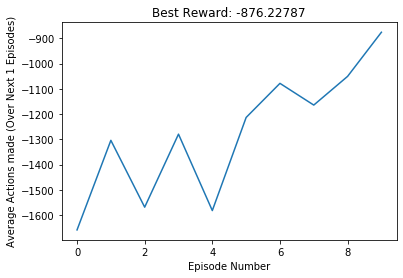

In [12]:
num_episodes = 10

agent = ReinforceAgentAdvanced(env)

best_score = -np.inf

avg_scores = deque(maxlen=num_episodes)

score_eval = ScoreEvaluator(1)

for i in range(num_episodes):  
    score = 0
    state = env.reset()
    agent.reset_episode()
    
    while True:
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        
        agent.step(state, reward, done)
        
        score += reward
        if done:
            score_eval.add(score)
            print_iteaction(i, score_eval)
            break
            
score_eval.plot_avg_scores()

state = env.reset()

for i in range(2):
    state = env.reset()
    while True:
        env.render()
        agent.reset_episode()
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        if done:
            break
        
env.close()

### DDPG Actor/Critic

In [7]:
import random
from collections import namedtuple, deque

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size: maximum size of buffer
            batch_size: size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self, batch_size=64):
        """Randomly sample a batch of experiences from memory."""
        return random.sample(self.memory, k=self.batch_size)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
import numpy as np
import copy

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu, theta, sigma):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

In [8]:
class DDPGAgent():
    """Reinforcement Learning agent that learns using DDPG."""
    def __init__(self, env):  
        self.env = env
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.action_high = env.action_space.high
        self.action_low = env.action_space.low
        self.action_range = self.action_high - self.action_low

        # Actor (Policy) Model
        self.actor_local = Actor(self.state_size, self.action_size, self.action_low, self.action_high)
        self.actor_target = Actor(self.state_size, self.action_size, self.action_low, self.action_high)

        # Critic (Value) Model
        self.critic_local = Critic(self.state_size, self.action_size)
        self.critic_target = Critic(self.state_size, self.action_size)

        # Initialize target model parameters with local model parameters
        self.critic_target.model.set_weights(self.critic_local.model.get_weights())
        self.actor_target.model.set_weights(self.actor_local.model.get_weights())

        # Noise process
        self.exploration_mu = 0
        self.exploration_theta = 0.15
        self.exploration_sigma = 0.2
        self.noise = OUNoise(self.action_size, self.exploration_mu, self.exploration_theta, self.exploration_sigma)

        # Replay memory
        self.buffer_size = 10000
        self.batch_size = 64
        self.memory = ReplayBuffer(self.buffer_size, self.batch_size)

        # Algorithm parameters
        self.gamma = 0.99  # discount factor
        self.tau = 0.01  # for soft update of target parameters

    def reset_episode(self):
        self.noise.reset()
        self.last_state = state

    def step(self, action, reward, next_state, done):
         # Save experience / reward
        self.memory.add(self.last_state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences)

        # Roll over last state and action
        self.last_state = next_state

    def act(self, state):
        """Returns actions for given state(s) as per current policy."""
        state = np.reshape(state, [-1, self.state_size])
        action = self.actor_local.model.predict(state)[0]
        return list(action + self.noise.sample())  # add some noise for exploration

    def learn(self, experiences):
        """Update policy and value parameters using given batch of experience tuples."""
        # Convert experience tuples to separate arrays for each element (states, actions, rewards, etc.)
        states = np.vstack([e.state for e in experiences if e is not None])
        actions = np.array([e.action for e in experiences if e is not None]).astype(np.float32).reshape(-1, self.action_size)
        rewards = np.array([e.reward for e in experiences if e is not None]).astype(np.float32).reshape(-1, 1)
        dones = np.array([e.done for e in experiences if e is not None]).astype(np.uint8).reshape(-1, 1)
        next_states = np.vstack([e.next_state for e in experiences if e is not None])

        # Get predicted next-state actions and Q values from target models
        #     Q_targets_next = critic_target(next_state, actor_target(next_state))
        actions_next = self.actor_target.model.predict_on_batch(next_states)
        Q_targets_next = self.critic_target.model.predict_on_batch([next_states, actions_next])

        # Compute Q targets for current states and train critic model (local)
        Q_targets = rewards + self.gamma * Q_targets_next * (1 - dones)
        self.critic_local.model.train_on_batch(x=[states, actions], y=Q_targets)

        # Train actor model (local)
        action_gradients = np.reshape(self.critic_local.get_action_gradients([states, actions, 0]), (-1, self.action_size))
        self.actor_local.train_fn([states, action_gradients, 1])  # custom training function

        # Soft-update target models
        self.soft_update(self.critic_local.model, self.critic_target.model)
        self.soft_update(self.actor_local.model, self.actor_target.model)   

    def soft_update(self, local_model, target_model):
        """Soft update model parameters."""
        local_weights = np.array(local_model.get_weights())
        target_weights = np.array(target_model.get_weights())

        assert len(local_weights) == len(target_weights), "Local and target model parameters must have the same size"

        new_weights = self.tau * local_weights + (1 - self.tau) * target_weights
        target_model.set_weights(new_weights)

### Actor-Critic method simplified

In [108]:
import tensorflow as tf
import numpy as np
import gym

from keras import layers, models, optimizers
from keras import backend as K
import keras

from ipdb import set_trace as debug

# np.random.seed(2)
# tf.set_random_seed(2)  # reproducible

sess = tf.Session()

import keras.backend as K

def gaussian(x):
    return K.exp(-K.pow(x,2))

class Actor():
    def __init__(self, env, lr=0.0001):
        self.env = env
        
        self.state_size = env.observation_space.shape
        self.action_size = env.action_space.shape[0]
        self.action_high = env.action_space.high
        self.action_low = env.action_space.low
        self.action_range = self.action_high - self.action_low

#         self.s = tf.placeholder(tf.float32, [1, n_features], "state")
#         self.a = tf.placeholder(tf.float32, None, name="act")
#         self.td_error = tf.placeholder(tf.float32, None, name="td_error")

        states = layers.Input(shape=self.state_size, name='states')
        
        layer_1 = layers.Dense(
            units=30,
            activation='relu',
            kernel_initializer=keras.initializers.RandomNormal(mean=.0,
                                                               stddev=.1),
            bias_initializer=keras.initializers.Constant(value=0.1),
        )(states)
        
        median = layers.Dense(
            units=1,
            activation='tanh',
            kernel_initializer=keras.initializers.RandomNormal(mean=.0,
                                                               stddev=.1),
            bias_initializer=keras.initializers.Constant(value=0.1),
        )(layer_1)
    
        sigma = layers.Dense(
            units=1,
            activation='softplus',
            kernel_initializer=keras.initializers.RandomNormal(mean=.0,
                                                               stddev=.1),
            bias_initializer=keras.initializers.Constant(value=1.),
        )(layer_1)
        
        combined = layers.concatenate([median, sigma])
        
        def gaussian(x):
            median, sigma = tf.squeeze(x[0][0]*2), tf.squeeze(x[0][1]+0.1)
            return K.random_normal((1,), mean=median, stddev=sigma)
#             return np.array([np.random.normal(median, abs(sigma))], dtype=float)
#             return tf.distributions.Normal(median, sigma)
        
        actions = layers.Activation(gaussian)(combined)
        
#         actions = layers.Lambda(gaussian)(combined)
        
        self.model = models.Model(inputs=[states], outputs=actions)
        
        # Define optimizer and compile model for training with built-in loss function
        optimizer = optimizers.Adam(lr=1e-3)
        self.model.compile(optimizer=optimizer, loss='mse')

#         # Compute action gradients (derivative of Q values w.r.t. to actions)
#         action_gradients = K.gradients(Q_values, actions)

#         # Define an additional function to fetch action gradients (to be used by actor model)
#         self.get_action_gradients = K.function(
#             inputs=[*self.model.input, K.learning_phase()],
#             outputs=action_gradients)
        
#         debug()
        
#         global_step = tf.Variable(0, trainable=False)

#         self.action = tf.clip_by_value(self.normal_dist.sample(1),
#                                        self.action_low,
#                                        self.action_high)

#         with tf.name_scope('exp_v'):
#             log_prob = self.normal_dist.log_prob(self.a)  # loss without advantage
            
#             self.exp_v = log_prob * self.td_error  # advantage (TD_error) guided loss
            
#             # Add cross entropy cost to encourage exploration
#             self.exp_v += 0.01*self.normal_dist.entropy()

#         with tf.name_scope('train'):
#             self.train_op = tf.train.AdamOptimizer(lr).minimize(-self.exp_v, global_step)    # min(v) = max(-v)

    def learn(self, state, action, td):
        s = s[np.newaxis, :]
        feed_dict = {self.s: s, self.a: a, self.td_error: td}
        _, exp_v = sess.run([self.train_op, self.exp_v], feed_dict)
        return exp_v

    def act(self, state):
        state = state[np.newaxis, :]
        return sess.run(self.action, {self.state: s})  # get probabilities for all actions

In [18]:
act = Actor(env)
act.model.predict(np.reshape([1,2,3], [-1, 3]))


[array([[0.37464064]], dtype=float32), array([[1.2310231]], dtype=float32)]

In [6]:
"""
Actor-Critic with continuous action using TD-error as the Advantage, Reinforcement Learning.
The Pendulum example (based on https://github.com/dennybritz/reinforcement-learning/blob/master/PolicyGradient/Continuous%20MountainCar%20Actor%20Critic%20Solution.ipynb)
Cannot converge!!! oscillate!!!
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
Using:
tensorflow r1.3
gym 0.8.0
"""

import tensorflow as tf
import numpy as np
import gym


sess = tf.Session()
np.random.seed(2)
tf.set_random_seed(2)  # reproducible


class Critic(object):
    def __init__(self, sess, n_features, lr=0.01):
        self.sess = sess
        with tf.name_scope('inputs'):
            self.s = tf.placeholder(tf.float32, [1, n_features], "state")
            self.v_ = tf.placeholder(tf.float32, [1, 1], name="v_next")
            self.r = tf.placeholder(tf.float32, name='r')

        with tf.variable_scope('Critic'):
            l1 = tf.layers.dense(
                inputs=self.s,
                units=30,  # number of hidden units
                activation=tf.nn.relu,
                kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='l1'
            )

            self.v = tf.layers.dense(
                inputs=l1,
                units=1,  # output units
                activation=None,
                kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='V'
            )

        with tf.variable_scope('squared_TD_error'):
            self.td_error = tf.reduce_mean(self.r + GAMMA * self.v_ - self.v)
            self.loss = tf.square(self.td_error)    # TD_error = (r+gamma*V_next) - V_eval
        with tf.variable_scope('train'):
            self.train_op = tf.train.AdamOptimizer(lr).minimize(self.loss)

    def learn(self, s, r, s_):
        s, s_ = s[np.newaxis, :], s_[np.newaxis, :]

        v_ = self.sess.run(self.v, {self.s: s_})
        td_error, _ = self.sess.run([self.td_error, self.train_op],
                                          {self.s: s, self.v_: v_, self.r: r})
        return td_error


OUTPUT_GRAPH = False
MAX_EPISODE = 1000
MAX_EP_STEPS = 200
DISPLAY_REWARD_THRESHOLD = -100  # renders environment if total episode reward is greater then this threshold
RENDER = False  # rendering wastes time
GAMMA = 0.9
LR_A = 0.001    # learning rate for actor
LR_C = 0.01     # learning rate for critic

env = gym.make('Pendulum-v0')
env.seed(1)  # reproducible
env = env.unwrapped

N_S = env.observation_space.shape[0]
A_BOUND = env.action_space.high

sess = tf.Session()

actor = Actor(env, lr=LR_A)
critic = Critic(sess, n_features=N_S, lr=LR_C)

sess.run(tf.global_variables_initializer())

if OUTPUT_GRAPH:
    tf.summary.FileWriter("logs/", sess.graph)

for i_episode in range(MAX_EPISODE):
    s = env.reset()
    t = 0
    ep_rs = []
    while True:
        if i_episode > 900:
            env.render()
        a = actor.choose_action(s)

        s_, r, done, info = env.step(a)
        r /= 10

        td_error = critic.learn(s, r, s_)  # gradient = grad[r + gamma * V(s_) - V(s)]
        actor.learn(s, a, td_error)  # true_gradient = grad[logPi(s,a) * td_error]

        s = s_
        t += 1
        ep_rs.append(r)
        if t > MAX_EP_STEPS:
            ep_rs_sum = sum(ep_rs)
            if 'running_reward' not in globals():
                running_reward = ep_rs_sum
            else:
                running_reward = running_reward * 0.9 + ep_rs_sum * 0.1
            if running_reward > DISPLAY_REWARD_THRESHOLD: RENDER = True  # rendering
            print("episode:", i_episode, "  reward:", int(running_reward))
            break

> <ipython-input-5-f66113186dff>(77)__init__()
     76 
---> 77         global_step = tf.Variable(0, trainable=False)
     78 



ipdb>  self.model.predict(np.array([1,2,3])


*** SyntaxError: unexpected EOF while parsing


ipdb>  self.model.predict(np.array([1,2,3]))


*** ValueError: Error when checking input: expected states to have shape (3,) but got array with shape (1,)


ipdb>  q


BdbQuit: 

### Actor-Critic method simplified 2

In [20]:
import tensorflow as tf
import numpy as np
import gym

from keras import layers, models, optimizers
from keras import backend as K
import keras

from ipdb import set_trace as debug

np.random.seed(37)
tf.set_random_seed(43)  # reproducible

sess = tf.Session()

import keras.backend as K

class Actor():
    def __init__(self, env, lr=0.0001, tau=0.001):
        self.env = env
        
        self.state_size = env.observation_space.shape
        self.action_size = env.action_space.shape
        self.action_high = env.action_space.high
        self.action_low = env.action_space.low
        self.action_range = self.action_high - self.action_low
        
        self.lr = lr
        self.tau = tau
        
        self.model, output_layer = self.build_network()
        self.target_model, _ = self.build_network()
        
        # Define Loss
        action_gradients = layers.Input(shape=self.action_size)
        loss = K.mean(-action_gradients*output_layer)
        
        # Get trainable parameters and define backprop optimization.
        adam_optimizer = optimizers.Adam(lr=self.lr)
        train_param = adam_optimizer.get_updates(params=self.model.trainable_weights,
                                                 loss=loss)
        
        # keras.backend.learning_phase() gives a flag to be passed as input
        # to any Keras function that uses a different behavior at train time and test time.
        self.train_fn = K.function(inputs=[self.model.input,
                                           action_gradients,
                                           K.learning_phase()], 
                                   outputs=[], 
                                   updates=train_param)     
    
    def build_network(self):
        states = layers.Input(shape=self.state_size, name='states')
        
        layer_1 = layers.Dense(
            units=256,
            activation='relu'
        )(states)
        layer_1 = layers.GaussianNoise(1.0)(layer_1)

        layer_2 = layers.Dense(
            units=128,
            activation='relu'
        )(layer_1)
        layer_2 = layers.GaussianNoise(1.0)(layer_2)

        output = layers.Dense(self.action_size[0],
                    activation='tanh',
                    kernel_initializer=keras.initializers.RandomUniform())(layer_2)
        output = layers.Lambda(lambda i: i * self.action_range)(output)

        return models.Model(inputs=[states], outputs=[output]), output
            
    def predict(self, state):
        prediction = self.model.predict(np.expand_dims(state, axis=0))
        
        return prediction[0]
    
    def transfer_learning(self):
        W, target_W = self.model.get_weights(), self.target_model.get_weights()
        for i in range(len(W)):
            target_W[i] = self.tau * W[i] + (1 - self.tau)* target_W[i]
        self.target_model.set_weights(target_W)

In [21]:
class Critic():
    def __init__(self, env, lr=0.0001, tau=0.001):
        self.env = env
        
        self.state_size = env.observation_space.shape
        self.action_size = env.action_space.shape
        self.action_high = env.action_space.high
        self.action_low = env.action_space.low
        self.action_range = self.action_high - self.action_low
        
        self.lr = lr
        self.tau = tau
        
        self.model = self.build_network()
        self.target_model = self.build_network()
        
        self.grads = K.function([self.model.input[0],
                                 self.model.input[1]],
                                K.gradients(self.model.output,
                                            self.model.input[1])) 
    
    def build_network(self):
        states = layers.Input(shape=self.state_size, name='states')
        actions = layers.Input(shape=self.action_size, name='actions')
        
        layer_1 = layers.Dense(
            units=256,
            activation='relu'
        )(states)
        
        layer_2 = layers.concatenate([layer_1, actions])
        
        layer_3 = layers.Dense(
            units=128,
            activation='relu'
        )(layer_2)
    
        output = layers.Dense(
            units=1,
            activation='linear',
            kernel_initializer=keras.initializers.RandomUniform()
        )(layer_3)

        model = models.Model(inputs=[states, actions], outputs=output)
        
        optimizer = optimizers.Adam(lr=self.lr)
        
        model.compile(optimizer=optimizer, loss='mse')
        
        return model
        
    def action_gradients(self, states, actions):
        return self.grads([states, actions])[0]
            
    def predict(self, state, action):
        return self.model.predict([np.expand_dims(state, axis=0),
                                   np.expand_dims(action, axis=0)])[0]
    
    def train_on_batch(self, states, actions, critic_target):
        return self.model.train_on_batch([states, actions],
                                         critic_target)
    
    def transfer_learning(self):
        W, target_W = self.model.get_weights(), self.target_model.get_weights()
        for i in range(len(W)):
            target_W[i] = self.tau * W[i] + (1 - self.tau)* target_W[i]
        self.target_model.set_weights(target_W)

In [22]:
class DDPG:
    """ Deep Deterministic Policy Gradient (DDPG) Helper Class
    """

    def __init__(self, env, buffer_size = 20000, batch_size=96,
                 gamma = 0.99, lr = 0.00005, tau = 0.001):
        """ Initialization
        """
        # Environment and A2C parameters
        
        self.state_size = env.observation_space.shape
        self.action_size = env.action_space.shape
        self.action_high = env.action_space.high
        self.action_low = env.action_space.low
        self.action_range = self.action_high - self.action_low

        self.gamma = gamma
        self.lr = lr
        # Create actor and critic networks
        self.actor = Actor(env, 0.1 * lr, tau)
        self.critic = Critic(env, lr, tau)

        self.batch_size = batch_size
        self.memory = ReplayBuffer(buffer_size, batch_size)

    def act(self, state):
        self.last_state = state
        return self.actor.predict(state)
    
    def step(self, action, reward, next_state, done):
        self.memory.add(self.last_state,
                        action,
                        reward,
                        next_state,
                        done)

        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences)

    def bellman(self, rewards, q_values, dones):
        critic_targets = np.asarray(q_values)
        for i in range(q_values.shape[0]):
            if dones[i]:
                critic_targets[i] = rewards[i]
            else:
                critic_targets[i] = rewards[i] + self.gamma * q_values[i]
        return critic_targets

    def memorize(self, state, action, reward, done, new_state):
        self.memory.add(state, action, reward, done, new_state)

    def sample_batch(self):
        return self.buffer.sample()

    def learn(self, experiences):
        states = np.vstack([e.state for e in experiences if e is not None])
        actions = (np.array([e.action for e in experiences if e is not None])
                     .astype(np.float32))
        rewards = (np.array([e.reward for e in experiences if e is not None])
                     .astype(np.float32))
        dones = (np.array([e.done for e in experiences if e is not None])
                   .astype(np.uint8))
        next_states = np.vstack([e.next_state for e in experiences if e is not None])
        
        q_values = (self.critic
                        .target_model
                        .predict([next_states,
                                  self.actor
                                      .target_model
                                      .predict(next_states)]))

        targets = self.bellman(rewards, q_values, dones)

        self.critic.train_on_batch(states, actions, targets)

        actions = self.actor.model.predict(states)
        gradients = self.critic.action_gradients(states, actions)
        
        self.actor.train_fn([states, gradients, 1])
        
        self.actor.transfer_learning()
        self.critic.transfer_learning()

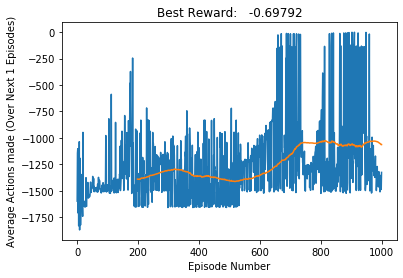

In [23]:
num_episodes = 1000

agent = DDPG(env)

best_score = -np.inf

avg_scores = deque(maxlen=num_episodes)

score_eval = ScoreEvaluator(1)

for i in range(num_episodes):  
    score = 0
    state = env.reset()
#     agent.reset_episode()
    
    while True:
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        
#         agent.step(state, reward, done)
        agent.step(action, reward, state, done)
        
        score += reward
        if done:
            score_eval.add(score)
            print_iteaction(i, score_eval)
            break
            
score_eval.plot_avg_scores()

### Training

In [25]:
state = env.reset()

for i in range(3):
    state = env.reset()
    while True:
        env.render()
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        if done:
            break
        
env.close()